# 1- Packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap

%matplotlib inline

# 2 - Data acquisition

In [2]:
Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe").set_index("Ticker")
price_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe last").set_index("Ticker")
price_USD_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe last USD").set_index("Ticker")
volume_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe volume").set_index("Ticker")
high_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe high").set_index("Ticker")
index_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe index").set_index("Ticker")
date_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe date").set_index("Ticker")

In [3]:
NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA").set_index("Ticker")
price_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA last").set_index("Ticker")
price_USD_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA last USD").set_index("Ticker")
volume_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA volume").set_index("Ticker")
high_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA high").set_index("Ticker")
index_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA index").set_index("Ticker")
date_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA date").set_index("Ticker")

In [9]:
Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia").set_index("Ticker")
price_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia last").set_index("Ticker")
price_USD_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia last USD").set_index("Ticker")
volume_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia volume").set_index("Ticker")
high_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia high").set_index("Ticker")
index_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia index").set_index("Ticker")
date_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia date").set_index("Ticker")

In [10]:
Global=Europe.append(NA).append(Asia)

In [11]:
def get_return(price_df,index_df):
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    index_return=index_df.diff(1,axis=1)/index_df.shift(1,axis=1)
    rel_return=abs_return-index_return
    rel_return_half=abs_return-0.5*index_return
    return abs_return,rel_return,rel_return_half

In [12]:
abs_return_Europe,rel_return_Europe,rel_return_half_Europe=get_return(price_Europe,index_Europe)
abs_return_NA,rel_return_NA,rel_return_half_NA=get_return(price_NA,index_NA)
abs_return_Asia,rel_return_Asia,rel_return_half_Asia=get_return(price_Asia,index_Asia)

In [13]:
abs_return=abs_return_Europe.dropna(how='all',axis=0).append(abs_return_NA.dropna(how='all',axis=0)).append(abs_return_Asia.dropna(how='all',axis=0))
rel_return=rel_return_Europe.dropna(how='all',axis=0).append(rel_return_NA.dropna(how='all',axis=0)).append(rel_return_Asia.dropna(how='all',axis=0))
rel_return_half=rel_return_half_Europe.dropna(how='all',axis=0).append(rel_return_half_NA.dropna(how='all',axis=0)).append(rel_return_half_Asia.dropna(how='all',axis=0))


In [142]:
liquidity_Europe=price_USD_Europe*volume_Europe/1000000.0
liquidity_NA=price_USD_NA*volume_NA/1000000.0
liquidity_Asia=price_USD_Asia*volume_Asia/1000000.0
liquidity_global=liquidity_Europe.append(liquidity_NA).append(liquidity_Asia)

In [15]:
price_index=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Index").set_index("Ticker")
abs_return_index=price_index.diff(1,axis=1)/price_index.shift(1,axis=1)

# 3 - Utility functions

In [16]:
def signal_simple_stop(signal_df,stop_level):
    signal_cum_move=((1+signal_df).cumprod()-1)
    signal_df_stop=signal_df[-(signal_cum_move.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [17]:
def signal_normal_stop(signal_df,return_df,stop_level):
    vol_column=signal_df.apply(lambda x: return_df.loc[x.name[0]].iloc[:x.name[2]].std(),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1)/vol_column
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [18]:
def signal_n_stop(signal_df,signal_df_abs,return_df,stop_level):
    vol_column=signal_df.apply(lambda x: return_df.loc[x.name[0]].iloc[:int(x.name[1])].std(),axis=0)
    signal_cum_nmove=((1+signal_df_abs).cumprod()-1)/vol_column
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [19]:
def signal_move_stop(signal_df,return_df,stop_level):
    vol_column=signal_df.apply(lambda x: return_df.loc[x.name[0]].iloc[:x.name[2]].std(),axis=0)
    signal_nmove=signal_df/vol_column
    signal_df_stop=signal_df[-(signal_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [20]:
def get_range(ticker,entry,price_df,holding):
    end_price=price_df.loc[ticker].iloc[entry+holding]
    high_price=price_df.loc[ticker].iloc[:entry+holding+1].max()
    low_price=price_df.loc[ticker].iloc[:entry+holding+1].min()
    range_price=(end_price-low_price)/(high_price-low_price)
    return range_price

In [21]:
def get_range_from_df(signal_df,price_df):
    end_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[x.name[2]+40],axis=0)
    high_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[:x.name[2]+40+1].max(),axis=0)
    low_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[:x.name[2]+40+1].min(),axis=0)
    range_price=(end_price-low_price)/(high_price-low_price)
    return range_price

In [305]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve=signal_account[0]
    avg_size=signal_account[1]
    gross=signal_account[2]
    ind_return=signal_account[3]
    turnover=signal_account[4]
    avg_holding=signal_account[5]
    stock_return=signal_account[6]
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2],loc=2)
    ax1.axhline(y=0,color='k')

    plt.show()

# 4 - Strategy by day

In [23]:
def trading_analytics(signal_df):
    ind_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    win=ind_return[ind_return>0]
    lose=ind_return[ind_return<0]
    count=ind_return.shape[0]
    hit_rate=win.shape[0]/count*1.0
    payoff=-win.mean()/lose.mean()*1.0
    avg_return=ind_return.mean()
    holding=signal_df.count(axis=0).mean()
    return count, hit_rate,payoff,avg_return,holding       

In [24]:
def IPO_long(data_df,price_df,high_df,return_df,Size,Open,Close,liquidity_constraint,start_day,end_day,holding,roll_range):
    
    '''
    high_df put in if want intraday high
    
    '''
    
    close_high_evaluate=(price_df.expanding(min_periods=start_day,axis=1).max()==price_df).iloc[:,start_day-1:end_day]
    
    if high_df is None:
        high_evaluate=close_high_evaluate
    else:
        intraday_high_evaluate=(high_df.expanding(min_periods=start_day,axis=1).max()==high_df).iloc[:,start_day-1:end_day]
        high_evaluate=close_high_evaluate & intraday_high_evaluate
    
    high_evaluate=high_evaluate[high_evaluate==True].dropna(how='all',axis=0)
       
    target_data=data_df[(data_df["Market_cap"]>=Size)&(data_df["Offer_Day1_Open"]>Open)&(data_df["Offer_Day1_Close"]>Close)\
                        &(data_df["liquidity"]>liquidity_constraint)]
    trade_day=high_evaluate.apply(lambda x:x.tolist().index(1.0),axis=1).reindex(target_data.index.tolist()).dropna()    
    end_range=trade_day.to_frame().apply(lambda x:get_range(x.name,int(x),price_df,holding),axis=1)
    
    target_return=return_df.loc[trade_day.index]
    signal_df=target_return.apply(lambda x:x[start_day+int(trade_day[x.name]):start_day+int(trade_day[x.name])+holding*2]\
                                  if end_range[x.name]>roll_range\
                                  else x[start_day+int(trade_day[x.name]):start_day+int(trade_day[x.name])+holding],axis=1)\
    # no need to shift as slicing takes idex from 0
    signal_df["Index"]=signal_df.apply(lambda x:(x.name,data_df["IPO_date"].loc[x.name],int(trade_day[x.name]+start_day+1))\
                                       ,axis=1) # plus 1 as the start date is one after the new high
    signal_df=signal_df.set_index("Index")
    return signal_df.T

In [145]:
signal_Europe_abs=IPO_long(Europe,price_Europe,None,abs_return_Europe,500,-2,-2,3,10,40,40,0.99)
signal_NA_abs=IPO_long(NA,price_NA,None,abs_return_NA,500,-2,-2,3,20,35,40,0.99)
signal_Asia_abs=IPO_long(Asia,price_Asia,None,abs_return_Asia,500,-2,-2,3,10,50,40,0.99)

In [63]:
## Build the abs signal
signal_Europe_abs=IPO_long(Europe,price_Europe,None,abs_return_Europe,500,-2,-2,3,5,100,40,0.99)
signal_NA_abs=IPO_long(NA,price_NA,None,abs_return_NA,500,-2,-2,3,5,100,40,0.99)
signal_Asia_abs=IPO_long(Asia,price_Asia,None,abs_return_Asia,500,-2,-2,3,5,100,40,0.99)

In [64]:
## Build the rel signal
signal_Europe_rel=IPO_long(Europe,price_Europe,None,rel_return_Europe,500,-2,-2,3,5,100,40,0.99)
signal_NA_rel=IPO_long(NA,price_NA,None,rel_return_NA,500,-2,-2,3,5,100,40,0.99)
signal_Asia_rel=IPO_long(Asia,price_Asia,None,rel_return_Asia,500,-2,-2,3,5,100,40,0.99)

In [65]:
## Build the half rel signal
signal_Europe_half_rel=IPO_long(Europe,price_Europe,None,rel_return_half_Europe,500,-2,-2,3,10,40,40,0.99)
signal_NA_half_rel=IPO_long(NA,price_NA,None,rel_return_half_NA,500,-2,-2,3,10,40,40,0.99)
signal_Asia_half_rel=IPO_long(Asia,price_Asia,None,rel_return_half_Asia,500,-2,-2,3,10,40,40,0.99)

# 5 - Account curve

In [219]:
def IPO_long_date(data_df,date_df,price_df,high_df,return_df,index_df,Size,Open,Close,liquidity_constraint,start_day,
                  end_day,holding,roll_range,start_date,end_date):
    
    close_high_evaluate=(price_df.expanding(min_periods=start_day,axis=1).max()==price_df).iloc[:,start_day-1:end_day]
    
    if high_df is None:
        high_evaluate=close_high_evaluate
    else:
        intraday_high_evaluate=(high_df.expanding(min_periods=start_day,axis=1).max()==high_df).iloc[:,start_day-1:end_day]
        high_evaluate=close_high_evaluate & intraday_high_evaluate
    
    high_evaluate=high_evaluate[high_evaluate==True].dropna(how='all',axis=0)
       
    target_data=data_df[(data_df["Market_cap"]>=Size)&(data_df["Offer_Day1_Open"]>Open)&(data_df["Offer_Day1_Close"]>Close)\
                        &(data_df["liquidity"]>liquidity_constraint)]
    trade_day=high_evaluate.apply(lambda x:x.tolist().index(1.0),axis=1).reindex(target_data.index.tolist()).dropna()    
    end_range=trade_day.to_frame().apply(lambda x:get_range(x.name,int(x),price_df,holding),axis=1)
    
    signal_df=index_df.to_frame().copy()
    for x, y in trade_day.to_dict().items():
        if end_range[x]>roll_range:            
            test_series=return_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding*2]
            test_series.index=date_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding*2].tolist()
        else:
            test_series=return_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding]
            test_series.index=date_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding].tolist()            
        signal_df=pd.concat([signal_df,test_series],axis=1)
    
    signal_df=signal_df.loc[start_date:end_date].iloc[:,1:]
    signal_df=signal_df.dropna(how="all",axis=1)
    
    signal_df.columns=signal_df.apply(lambda x:(x.name,trade_day[x.name]+start_day,x.dropna().index[0]),axis=0)
    signal_df=signal_df.loc[:,signal_df.apply(lambda x:x.name[2]>start_date and x.name[2]<end_date,axis=0)]
    signal_df=signal_df.dropna(how="all",axis=1)

    return signal_df

In [77]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal_account_LS_parity(signal_df,data_df,return_df,size_low,size_high,capital,liquidity,liquidity_constraint,hedge):
    #average_number=signal_df.count(axis=1).mean()
    #avg_size=average_gross/100/average_number
    vol_row=signal_df.apply(lambda x: return_df.loc[x.name[0]][:int(x.name[1])].std(),axis=0)
    size_row=signal_df.apply(lambda x: min(size_high*vol_row.mean()/vol_row[x.name],liquidity.loc[x.name[0]][:int(x.name[1])]\
                                           [-10:].mean()*liquidity_constraint)/capital \
                             if (data_df.loc[x.name[0]]["Offer_Day1_Open"]>0) & (data_df.loc[x.name[0]]["Offer_Day1_Close"]>0)\
                             else min(size_low*vol_row.mean()/vol_row[x.name],liquidity.loc[x.name[0]]\
                                      [:int(x.name[1])][-10:].mean()*liquidity_constraint)/capital,axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    if hedge=='abs':
        gross=size_df.sum(axis=1)
    elif hedge=='rel':
        gross=size_df.sum(axis=1)*2
    else:
        gross=size_df.sum(axis=1)*1.5
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    cache=(count,size_row)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df,cache

In [78]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal_account_LS(signal_df,data_df,size_low,size_high,capital,liquidity,liquidity_constraint,hedge):
    #average_number=signal_df.count(axis=1).mean()
    #avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(size_high,liquidity.loc[x.name[0]][:int(x.name[1])][-10:].mean()*liquidity_constraint)/capital \
                             if (data_df.loc[x.name[0]]["Offer_Day1_Open"]>0) & (data_df.loc[x.name[0]]["Offer_Day1_Close"]>0)\
                             else min(size_low,liquidity.loc[x.name[0]][:int(x.name[1])][-10:].mean()*liquidity_constraint)/capital,axis=0)
 
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    if hedge=='abs':
        gross=size_df.sum(axis=1)
    elif hedge=='rel':
        gross=size_df.sum(axis=1)*2
    else:
        gross=size_df.sum(axis=1)*1.5
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    cache=(count,size_row)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df,cache

In [300]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)-(1+account_curve).cummax(axis=0)).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [274]:
#signal_abs_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,abs_return_Europe,abs_return_index.loc["SX5E Index"],\
#                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,8,1),pd.Timestamp(2019,3,29))
signal_abs_NA_date=IPO_long_date(NA,date_NA,price_NA,None,abs_return_NA,abs_return_index.loc["SPX Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,9,1),pd.Timestamp(2019,3,29))
signal_abs_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,abs_return_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,9,1),pd.Timestamp(2019,3,29))
signal_abs_date=pd.concat([signal_abs_NA_date,signal_abs_Asia_date],axis=1)

In [251]:
signal_abs_Europe_date_full=IPO_long_date(Europe,date_Europe,price_Europe,None,abs_return_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_abs_NA_date_full=IPO_long_date(NA,date_NA,price_NA,None,abs_return_NA,abs_return_index.loc["SPX Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_abs_Asia_date_full=IPO_long_date(Asia,date_Asia,price_Asia,None,abs_return_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_abs_date_full=pd.concat([signal_abs_Europe_date_full,signal_abs_NA_date_full,signal_abs_Asia_date_full],axis=1)

In [226]:
signal_rel_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,rel_return_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,7,1),pd.Timestamp(2019,3,29))
signal_rel_NA_date=IPO_long_date(NA,date_NA,price_NA,None,rel_return_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,7,1),pd.Timestamp(2019,3,29))
signal_rel_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,rel_return_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,7,1),pd.Timestamp(2019,3,29))
signal_rel_date=pd.concat([signal_rel_Europe_date,signal_rel_NA_date,signal_rel_Asia_date],axis=1)

In [271]:
signal_half_rel_Europe_date_intraday=IPO_long_date(Europe,date_Europe,price_Europe,high_Europe,rel_return_half_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,40,40,0.99,pd.Timestamp(2018,8,1),pd.Timestamp(2019,3,29))
signal_half_rel_NA_date_intraday=IPO_long_date(NA,date_NA,price_NA,high_NA,rel_return_half_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,40,40,0.99,pd.Timestamp(2018,8,1),pd.Timestamp(2019,3,29))
signal_half_rel_Asia_date_intraday=IPO_long_date(Asia,date_Asia,price_Asia,high_Asia,rel_return_half_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,40,40,0.99,pd.Timestamp(2018,8,1),pd.Timestamp(2019,3,29))
signal_half_rel_date_intraday=pd.concat([signal_half_rel_Europe_date_intraday,signal_half_rel_NA_date_intraday,signal_half_rel_Asia_date_intraday],axis=1)

In [275]:
#signal_half_rel_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,rel_return_half_Europe,abs_return_index.loc["SX5E Index"],\
#                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,9,1),pd.Timestamp(2019,3,29))
signal_half_rel_NA_date=IPO_long_date(NA,date_NA,price_NA,None,rel_return_half_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,9,1),pd.Timestamp(2019,3,29))
signal_half_rel_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,rel_return_half_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2018,9,1),pd.Timestamp(2019,3,29))
signal_half_rel_date=pd.concat([signal_half_rel_NA_date,signal_half_rel_Asia_date],axis=1)

In [246]:
signal_half_rel_Europe_date_full=IPO_long_date(Europe,date_Europe,price_Europe,None,rel_return_half_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_half_rel_NA_date_full=IPO_long_date(NA,date_NA,price_NA,None,rel_return_half_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_half_rel_Asia_date_full=IPO_long_date(Asia,date_Asia,price_Asia,None,rel_return_half_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99,pd.Timestamp(2010,7,1),pd.Timestamp(2019,3,29))
signal_half_rel_date_full=pd.concat([signal_half_rel_Europe_date_full,signal_half_rel_NA_date_full,signal_half_rel_Asia_date_full],axis=1)

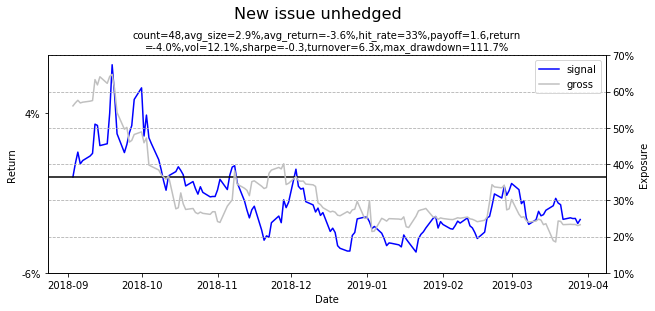

In [280]:
plot_account_curve(signal_account_LS(signal_half_rel_date,Global,2,3,50,liquidity_global,0.2,'abs'),'Date',\
                   'New issue unhedged',[10,4])


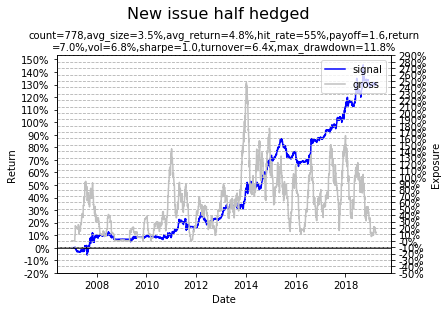

In [109]:
plot_account_curve(signal_account_LS(signal_abs_date,Global,2,3,50,liquidity_global,0.2,'half'),'Date','New issue half hedged',[6,4])


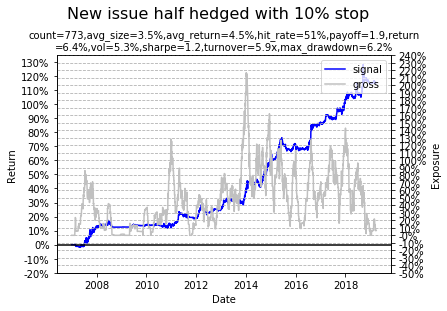

In [110]:
plot_account_curve(signal_account_LS(signal_simple_stop(signal_half_rel_date,0.1),Global,2,3,50,liquidity_global,0.2,'half'),'Date','New issue half hedged with 10% stop',[6,4])


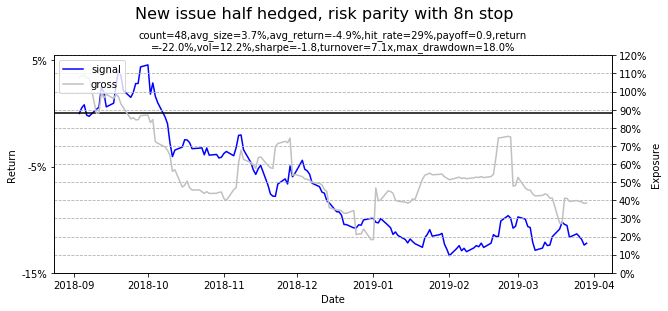

In [306]:
plot_account_curve(signal_account_LS_parity(signal_n_stop(signal_half_rel_date,signal_abs_date,abs_return,8),Global,abs_return,2,3,50,liquidity_global,\
                                     0.2,'half'),'Date','New issue half hedged, risk parity with 8n stop',[10,4])

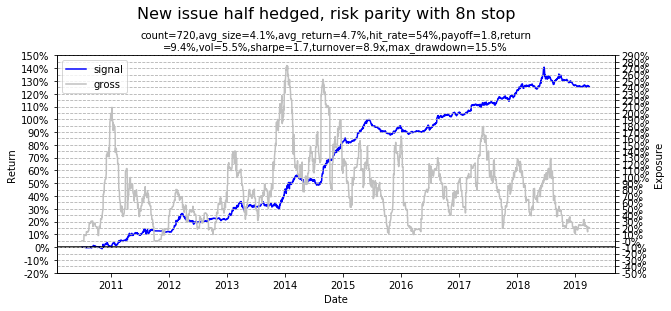

In [307]:
plot_account_curve(signal_account_LS_parity(signal_n_stop(signal_half_rel_date_full,signal_abs_date_full,abs_return,8),Global,abs_return,2,3,50,liquidity_global,\
                                     0.2,'half'),'Date','New issue half hedged, risk parity with 8n stop',[10,4])

In [309]:
signal_half_rel_date.to_csv("IPO.csv")